# Sentiment Analysis of ESG News Articles

In this notebook, we aim to perform a sentiment analysis on ESG-related news articles.
We work with a labeled dataset containing three sentiment classes: Positive, Neutral, and Negative.

The workflow includes:
- Loading and preprocessing the news dataset.
- Tokenizing the articles using the RoBERTa tokenizer.
- Defining a RoBERTa-based classification model with a multi-head attention mechanism and feed-forward layers.
- Fine-tuning the model on the sentiment classification task.
- Applying early stopping to prevent overfitting.
- Evaluating model performance using standard classification metrics and confusion matrices.

The goal is to develop a reliable model capable of categorizing ESG news into sentiment categories,
providing deeper insights into the tone of ESG communications in financial markets.

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer
from transformers import RobertaModel
from sklearn.utils import resample

In [ ]:
path = '/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/sentiment_sample_e_s_g.csv'
df = pd.read_csv(path)
df

,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description,text,esg_pred,esg_type,predicted_sentiment
0,NaN,2021-08-03T03:06:08Z,Tesla's India Plans Dealt Blow As Minister Rul...,Elon Musk has complained that Indian rules pro...,NDTV News,NaN,NaN,tesla,NaN,https://www.ndtv.com/india-news/teslas-india-p...,TSLA,India said it has no plans to cut import dutie...,Tesla's India Plans Dealt Blow As Minister Rul...,1,2,bearish
1,NaN,2022-11-18T17:00:16Z,Black Tech Workers Share Anxious Mood Inside A...,The year has left the tech industry battered a...,Business Insider,NaN,NaN,apple,NaN,https://www.businessinsider.com/black-tech-wor...,AAPL,"At the AfroTech conference, Black tech workers...",Black Tech Workers Share Anxious Mood Inside A...,1,1,neutral
2,NaN,2021-09-21T01:13:12Z,New study says the moon might impact sleep qua...,Most modern wearable devices offer sleep track...,BGR,NaN,NaN,apple,NaN,https://bgr.com/science/new-study-says-the-moo...,AAPL,Most modern wearable devices offer sleep track...,New study says the moon might impact sleep qua...,1,1,neutral
3,NaN,2021-04-12T14:30:43Z,Google and Apple block update to England’s con...,An update to England and Wales contact-tracing...,The Next Web,NaN,NaN,google,NaN,https://thenextweb.com/news/nhs-covid-19-conta...,GOOGL,An update to England and Wales’ contact-tracin...,Google and Apple block update to England’s con...,1,2,bearish
4,2407.0,2023-12-06 20:25:03+00:00,There's an uptick in Amazon employees quitting...,Some Amazon employees have noticed an increasi...,Business Insider,negative,1.0,amazon,Technology,NaN,AMZN,NaN,There's an uptick in Amazon employees quitting...,1,1,bearish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,NaN,2020-08-28T01:07:39Z,"Champ pays tribute to BLM with shoes, message","OLYMPIA FIELDS, Ill. -- There was not a lot of...",ESPN,NaN,NaN,nike,NaN,https://www.espn.com/golf/story/_/id/29755957/...,NKE,"Cameron Champ had the word ""equality"" written ...","Champ pays tribute to BLM with shoes, message....",1,1,neutral
7996,NaN,2021-08-31T19:11:44Z,Johnson & Johnson HIV vaccine trial fails mid-...,In yet another setback in the decadeslong scie...,ABC News,NaN,NaN,johnson & johnson,NaN,https://abcnews.go.com/Health/johnson-johnson-...,JNJ,A Johnson & Johnson HIV vaccine candidate fail...,Johnson & Johnson HIV vaccine trial fails mid-...,1,1,bearish
7997,NaN,2022-06-28T16:02:02Z,Microsoft must get better in reporting global ...,Britain-based proxy advisers Pensions &amp; In...,Neowin,NaN,NaN,microsoft,NaN,https://www.neowin.net/news/microsoft-must-get...,MSFT,Microsoft should submit a tax transparency rep...,Microsoft must get better in reporting global ...,1,2,neutral
7998,NaN,2020-08-17 08:15:00,Oil: Sector Ready To Double - How To Play It,US oil production bounced back but remained ne...,Seeking Alpha,NaN,NaN,conocophillips,NaN,https://seekingalpha.com/article/4368470-oil-s...,COP,NaN,Oil: Sector Ready To Double - How To Play It. ...,1,0,bullish


In [ ]:
sentiment_mapping = {
    'bearish': 0,
    'neutral': 1,
    'bullish': 2
}

df['sentiment_id'] = df['predicted_sentiment'].map(sentiment_mapping)

In [ ]:
class_0 = df[df['sentiment_id'] == 0]
class_1 = df[df['sentiment_id'] == 1]
class_2 = df[df['sentiment_id'] == 2]

class_0_downsampled = resample(class_0, replace=False, n_samples=2312, random_state=42)
class_1_downsampled = resample(class_1, replace=False, n_samples=2312, random_state=42)

df = pd.concat([class_0_downsampled, class_1_downsampled, class_2]).sample(frac=1, random_state=33).reset_index(drop=True)

In [ ]:
df['sentiment_id'].value_counts()

,count
sentiment_id,
0,2312
2,2312
1,2312


In [ ]:
df_sampled = df[['text', 'sentiment_id']]

,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description,text,esg_pred,esg_type,predicted_sentiment,sentiment_id
0,NaN,2021-06-25T10:46:58Z,Are Amazon and Google encouraging fake reviews,Amazon and Google are under investigation due ...,PhoneArena,NaN,NaN,google,NaN,https://www.phonearena.com/news/are-reviews-on...,GOOGL,Amazon and Google are under investigation due ...,Are Amazon and Google encouraging fake reviews...,1,2,bearish,0
1,NaN,2020-10-07T22:47:58Z,"Tesla to produce 500,000 cars in 2020, says Mu...","According to Reuters, Elon Musk has shared an ...",MobileSyrup,NaN,NaN,tesla,NaN,https://mobilesyrup.com/2020/10/07/tesla-half-...,TSLA,"According to Reuters, Elon Musk has shared an ...","Tesla to produce 500,000 cars in 2020, says Mu...",1,0,bullish,2
2,NaN,2024-06-18 16:20:24,Amazon hit with $5.9 million fine for violatin...,California's labor regulator slapped Amazon wi...,CNBC,NaN,NaN,amazon,NaN,https://www.cnbc.com/2024/06/18/amazon-hit-wit...,AMZN,NaN,Amazon hit with $5.9 million fine for violatin...,1,1,bearish,0
3,3219.0,2023-06-18 21:44:11+00:00,Ancient Amazon Charcoal Seen as Next Big Thing...,(Bloomberg) --\nTucker Carlson's Fox Defense C...,Yahoo! Finance France (French),NaN,NaN,jpmorgan,Finance,https://ca.finance.yahoo.com/news/ancient-amaz...,NaN,NaN,Ancient Amazon Charcoal Seen as Next Big Thing...,1,0,bullish,2
4,NaN,2021-06-07T09:35:24Z,Back To The Office? No Thanks…,IMAGE:\r\nMediaNews Group via Getty Images\r\n...,Forbes,NaN,NaN,apple,NaN,https://www.forbes.com/sites/enriquedans/2021/...,AAPL,"On June 2, Apple announced that from September...",Back To The Office? No Thanks…. IMAGE:\r\nMedi...,1,1,neutral,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6931,NaN,2021-05-04T14:10:00Z,NACI advice on 'preferred vaccines' for COVID-...,The National Advisory Committee on Immunizatio...,Castanet.net,NaN,NaN,johnson & johnson,NaN,https://www.castanet.net/news/Canada/332863/NA...,JNJ,<ol><li>NACI advice on 'preferred vaccines' fo...,NACI advice on 'preferred vaccines' for COVID-...,1,1,neutral,1
6932,NaN,2022-09-14T01:36:00Z,"Meet ANGIE, the ATO's secret weapon to beat we...",It really is around bringing transparency to c...,Australian Financial Review,NaN,NaN,netflix,NaN,https://www.afr.com/politics/federal/meet-angi...,NFLX,The Tax Office has deployed Netflix-like techn...,"Meet ANGIE, the ATO's secret weapon to beat we...",1,2,neutral,1
6933,10634.0,2023-02-17 14:36:01+00:00,Apple's Cook and Amazon’s Jassy are among the ...,The pay for many CEOs soared as the U.S. econo...,Upworthy,NaN,NaN,apple,Technology,https://biztoc.com/x/b46adf5d096997c4?ref=ff,AAPL,NaN,Apple's Cook and Amazon’s Jassy are among the ...,1,2,bearish,0
6934,NaN,2021-12-27T06:44:15Z,India roundup: Apple to make iPhone 13 in India,Apple begins trial production of iPhone 13 in ...,Digitimes,NaN,NaN,apple,NaN,https://www.digitimes.com/news/a20211227VL202....,AAPL,Apple begins trial production of iPhone 13 in ...,India roundup: Apple to make iPhone 13 in Indi...,1,2,bullish,2


In [ ]:
df_sampled

,text,sentiment_id
0,Are Amazon and Google encouraging fake reviews...,0
1,"Tesla to produce 500,000 cars in 2020, says Mu...",2
2,Amazon hit with $5.9 million fine for violatin...,0
3,Ancient Amazon Charcoal Seen as Next Big Thing...,2
4,Back To The Office? No Thanks…. IMAGE:\r\nMedi...,1
...,...,...
6931,NACI advice on 'preferred vaccines' for COVID-...,1
6932,"Meet ANGIE, the ATO's secret weapon to beat we...",1
6933,Apple's Cook and Amazon’s Jassy are among the ...,0
6934,India roundup: Apple to make iPhone 13 in Indi...,2


In [ ]:
df_balanced = df_sampled.rename(columns={'sentiment_id': 'label'})
df_balanced = df_sampled.rename(columns={'text': 'body'})

,text,sentiment_id
0,Are Amazon and Google encouraging fake reviews...,0
1,"Tesla to produce 500,000 cars in 2020, says Mu...",2
2,Amazon hit with $5.9 million fine for violatin...,0
3,Ancient Amazon Charcoal Seen as Next Big Thing...,2
4,Back To The Office? No Thanks…. IMAGE:\r\nMedi...,1
...,...,...
6931,NACI advice on 'preferred vaccines' for COVID-...,1
6932,"Meet ANGIE, the ATO's secret weapon to beat we...",1
6933,Apple's Cook and Amazon’s Jassy are among the ...,0
6934,India roundup: Apple to make iPhone 13 in Indi...,2


In [ ]:
df_balanced = df_sampled.rename(columns={'sentiment_id': 'label'})
df_balanced

,text,label
0,Are Amazon and Google encouraging fake reviews...,0
1,"Tesla to produce 500,000 cars in 2020, says Mu...",2
2,Amazon hit with $5.9 million fine for violatin...,0
3,Ancient Amazon Charcoal Seen as Next Big Thing...,2
4,Back To The Office? No Thanks…. IMAGE:\r\nMedi...,1
...,...,...
6931,NACI advice on 'preferred vaccines' for COVID-...,1
6932,"Meet ANGIE, the ATO's secret weapon to beat we...",1
6933,Apple's Cook and Amazon’s Jassy are among the ...,0
6934,India roundup: Apple to make iPhone 13 in Indi...,2


In [ ]:
df_balanced = df_balanced.rename(columns={'text': 'body'})

## 3. Tokenization and Dataset Preparation

### 3.1 Tokenizer Initialization
We use the `RobertaTokenizer` from the `roberta-base` model to process the input texts.
We set the maximum sequence length to **256 tokens** to:
- **Balance computational cost and information retention**: Longer sequences could capture more context but drastically increase memory usage and training time.
- **Prevent memory overflow** during batch processing on GPUs.
- **Standardize input size** for efficient batch computation.

### 3.2 Encoding Function
The `encode_texts` function tokenizes entire batches of texts with:
- **Truncation**: Texts longer than 256 tokens are cut off. This prevents unexpected shape mismatches and maintains training stability.
- **Padding**: Shorter texts are padded to 256 tokens to allow efficient batch processing.
- **Return tensors**: Data is converted directly into PyTorch tensors for integration into the training pipeline.

These steps are necessary to create uniform input shapes, as transformers expect inputs of the same length within a batch.

### 3.3 Stratified Train/Validation/Test Split
The dataset is split as follows:
- **70% Training**
- **15% Validation**
- **15% Test**

Using `stratify=y` ensures that the proportion of each class (positive, neutral, negative) remains consistent across splits.  

### 3.4 Dataset and DataLoader Creation
Each split (train/val/test) is converted into a `TensorDataset` consisting of:
- `input_ids`: Encoded token indices.
- `attention_mask`: Binary mask to ignore padding tokens during attention.
- `labels`: The corresponding sentiment label.

We use `DataLoader` to load batches of size **16**:
- A batch size of 16 strikes a balance between **training speed and memory usage**.
- In training, **shuffling** (`shuffle=True`) ensures that the model generalizes better by seeing examples in different orders.
- In validation and testing, **no shuffling** (`shuffle=False`) is used to guarantee consistent and repeatable evaluation.

### Summary of Design Decisions
| Step                         | Decision Made                          | Justification |
|-------------------------------|----------------------------------------|---------------|
| Tokenizer                     | RobertaTokenizer (`roberta-base`)      | Compatibility with pre-trained RoBERTa model |
| Maximum Sequence Length       | 256 tokens                             | Memory-efficient and retains sufficient context |
| Dataset Split                 | 70% / 15% / 15% with stratification    | Fair distribution of classes across datasets |
| Batch Size                    | 16                                     | Balance between speed and memory usage |
| Shuffle in Training           | Yes                                    | Improve model generalization |
| Shuffle in Validation/Test    | No                                     | Consistent evaluation |

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_len = 256

def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

X_train, X_temp, y_train, y_temp = train_test_split(df_balanced['body'], df_balanced['label'], test_size=0.3, stratify=df_balanced['label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

train_encodings = encode_texts(X_train.tolist())
val_encodings = encode_texts(X_val.tolist())
test_encodings = encode_texts(X_test.tolist())

dataset_train = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
dataset_val = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val.values))
dataset_test = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)

## Enhanced Model Architecture: NewsSentimentAttentionModel

In this section, we present an enhanced model architecture designed for ESG news classification, leveraging both the strengths of RoBERTa embeddings and a custom attention-processing block inspired by Transformer encoder layers.

The `NewsSentimentAttentionModel` builds upon three major components:

- **Base Encoder**: The `roberta-base` model is employed to generate contextual embeddings from the input text. RoBERTa captures the semantic and syntactic relationships in the news articles, providing a rich representation of each token.

- **Attention and Processing Block**:  
  To further refine the embeddings, a Multi-Head Attention mechanism with four heads is applied to the token representations. A residual connection and Layer Normalization are introduced after the attention operation, promoting stable and efficient learning.  
  Subsequently, a small feedforward network (position-wise dense layer with ReLU activation and dropout) is applied, again followed by a residual connection and Layer Normalization.  
  This design mimics the internal structure of standard Transformer encoders, allowing the model to enhance important signals in the text while maintaining computational efficiency.

- **Final Classification Head**:  
  After the sequence processing, a mean pooling operation aggregates the information across the token dimension into a single fixed-size vector per article.  
  This vector is passed through a fully connected layer with ReLU activation and dropout for regularization, followed by a final output layer that produces logits for the three ESG classes (Environmental, Social, Governance).

### Key Advantages

The inclusion of an attention block with residual connections and normalization significantly improves the model's ability to focus on critical parts of the news while preserving long-range dependencies within the text.  
This architecture seeks to boost the model’s capability to capture fine-grained ESG signals embedded in financial and corporate narratives, leading to more accurate and robust classifications.

In [ ]:
class NewsSentimentAttentionModel(nn.Module):
    def __init__(self):
        super(NewsSentimentAttentionModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=4, batch_first=True)
        self.norm1 = nn.LayerNorm(768)
        self.ff = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(768, 768)
        )
        self.norm2 = nn.LayerNorm(768)

        self.fc1 = nn.Linear(768, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state

        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)

        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)

        pooled_output = x.mean(dim=1)

        x = self.fc1(pooled_output)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Model Instantiation and Fine-Tuning Setup

In this step, we instantiate the `NewsSentimentAttentionModel` and prepare it for fine-tuning.  
To leverage the pretrained knowledge from RoBERTa while adapting it efficiently to our ESG classification task, we apply a **partial fine-tuning** strategy:

- Only the last four transformer layers (`layer.8`, `layer.9`, `layer.10`, `layer.11`) of RoBERTa are set to be trainable.  
- All earlier layers are frozen to preserve the general linguistic representations already learned and to reduce computational cost and risk of overfitting.

This selective fine-tuning approach strikes a balance between adaptation and stability, as updating only higher layers typically allows the model to specialize to the new task without losing its pretrained capabilities (Howard & Ruder, 2018).

The model is moved to the appropriate device (GPU if available, otherwise CPU), and the following optimization settings are defined:

- **Optimizer**: AdamW optimizer is used with a learning rate of \( 2 \times 10^{-5} \), which is a standard choice for fine-tuning transformer-based architectures.
- **Loss Function**: Cross-Entropy Loss is selected, appropriate for multiclass classification problems where each example belongs to one and only one class.

This configuration prepares the model for efficient and stable fine-tuning on the ESG news classification dataset.

In [ ]:
model = NewsSentimentAttentionModel()
for name, param in model.roberta.named_parameters():
    if "layer.8." in name or "layer.9." in name or "layer.10." in name or "layer.11." in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

Epoch 1/10, Train Loss: 0.7503, Train Acc: 0.6408, Val Loss: 0.5405, Val Acc: 0.7654
Epoch 2/10, Train Loss: 0.5141, Train Acc: 0.7909, Val Loss: 0.5234, Val Acc: 0.7731
Epoch 3/10, Train Loss: 0.4084, Train Acc: 0.8373, Val Loss: 0.5438, Val Acc: 0.7750
EarlyStopping counter: 1 out of 3
Epoch 4/10, Train Loss: 0.3190, Train Acc: 0.8805, Val Loss: 0.6490, Val Acc: 0.7635
EarlyStopping counter: 2 out of 3
Epoch 5/10, Train Loss: 0.2410, Train Acc: 0.9096, Val Loss: 0.7006, Val Acc: 0.7644
EarlyStopping counter: 3 out of 3
Early stopping
              precision    recall  f1-score   support

    Negative       0.79      0.86      0.83       347
     Neutral       0.71      0.65      0.68       347
    Positive       0.83      0.84      0.84       347

    accuracy                           0.78      1041
   macro avg       0.78      0.78      0.78      1041
weighted avg       0.78      0.78      0.78      1041



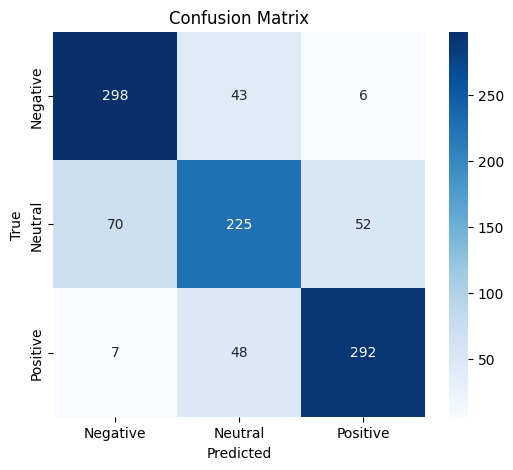

In [ ]:
num_epochs = 10
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for batch in train_loader:
        batch = [item.to(device) for item in batch]
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == labels)

    train_loss = total_loss / len(train_loader)
    train_acc = correct.double() / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels)

    val_loss /= len(val_loader)
    val_acc = correct.double() / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = [item.to(device) for item in batch]
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/news_second_classified.csv'
df_trainning = pd.read_csv(path)

<ipython-input-29-0710197a5e40>:2: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trainning = pd.read_csv(path)


In [ ]:
df_inference = df_trainning.copy()
df_inference

,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description,text,esg_pred,esg_type
0,3.0,2024-07-18 14:19:34+00:00,How ToxMod's AI impacted toxicity in Call of D...,It's no secret Call of Duty has toxic players....,DNyuz,neutral,0.48,activision,Communication,NaN,ATVI,NaN,How ToxMod's AI impacted toxicity in Call of D...,1,1
1,4.0,2024-07-18 14:04:50+00:00,How ToxMod's AI impacted toxicity in Call of D...,It's no secret Call of Duty has toxic players....,Allusanewshub,neutral,0.54,activision,Communication,NaN,ATVI,NaN,How ToxMod's AI impacted toxicity in Call of D...,1,1
2,5.0,2024-05-27 07:03:20+00:00,"Meta, Activision Sued by Families of Uvalde Sc...",In the wake of the tragic shooting at Robb Ele...,Tech Times,neutral,0.92,activision,Communication,NaN,ATVI,NaN,"Meta, Activision Sued by Families of Uvalde Sc...",1,1
3,8.0,2024-04-02 15:34:29+00:00,Federal racial discrimination lawsuit against ...,"'In Tesla's narrative, the agencies learned no...",Head Topics,negative,0.41,activision,Communication,NaN,ATVI,NaN,Federal racial discrimination lawsuit against ...,1,1
4,11.0,2024-01-24 03:28:56+00:00,Activision Will Pay $50 Million to Settle Work...,Activision Blizzard will pay roughly $50 milli...,Mytimesnow,positive,0.64,activision,Communication,NaN,ATVI,NaN,Activision Will Pay $50 Million to Settle Work...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431215,NaN,2025-03-21 10:50:51,Nike is starting to show green-shoots with inn...,"Andrea Andreeva, Piper Sandler analyst, joins ...",CNBC Television,NaN,NaN,nike,NaN,https://www.youtube.com/watch?v=yrwUTpiLvsI,NKE,NaN,Nike is starting to show green-shoots with inn...,1,2
431216,NaN,2025-03-21 11:19:37,"Nike Stock Plummets on Dismal Forecast, Bear N...",Brushing off a fiscal third-quarter earnings a...,Schaeffers Research,NaN,NaN,nike,NaN,https://www.schaeffersresearch.com/content/new...,NKE,NaN,"Nike Stock Plummets on Dismal Forecast, Bear N...",1,2
431217,NaN,2025-03-21 11:20:15,Nike Turnaround Hits Snags Amid Inventory Rese...,Nike's turnaround effort is facing challenges ...,Bloomberg Markets and Finance,NaN,NaN,nike,NaN,https://www.youtube.com/watch?v=T4MRIaMz2ks,NKE,NaN,Nike Turnaround Hits Snags Amid Inventory Rese...,1,2
431218,NaN,2025-03-21 12:31:54,Why Nike Stock Got Tripped Up Today,Shares of Nike (NKE -5.16%) fell Friday mornin...,The Motley Fool,NaN,NaN,nike,NaN,https://www.fool.com/investing/2025/03/21/why-...,NKE,NaN,Why Nike Stock Got Tripped Up Today. Shares of...,1,2


In [ ]:
encodings = encode_texts(df_inference['text'])

In [ ]:
dataset_inference = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
inference_loader = DataLoader(dataset_inference, batch_size=32, shuffle=False)

In [ ]:
model.eval()

predictions = []

with torch.no_grad():
    for batch in inference_loader:
        input_ids, attention_mask = [item.to(device) for item in batch]
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

In [ ]:
label_mapping = {0: 'bearish', 1: 'neutral', 2: 'bullish'}
df_inference['sentimiento_predicho'] = [label_mapping[p] for p in predictions]

In [ ]:
conteo_sentimientos = df_inference['sentimiento_predicho'].value_counts()
print(conteo_sentimientos)

sentimiento_predicho
bearish    149725
neutral    145726
bullish    135769
Name: count, dtype: int64


In [ ]:
df_inference

,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description,text,esg_pred,esg_type,sentimiento_predicho
0,3.0,2024-07-18 14:19:34+00:00,How ToxMod's AI impacted toxicity in Call of D...,It's no secret Call of Duty has toxic players....,DNyuz,neutral,0.48,activision,Communication,NaN,ATVI,NaN,How ToxMod's AI impacted toxicity in Call of D...,1,1,neutral
1,4.0,2024-07-18 14:04:50+00:00,How ToxMod's AI impacted toxicity in Call of D...,It's no secret Call of Duty has toxic players....,Allusanewshub,neutral,0.54,activision,Communication,NaN,ATVI,NaN,How ToxMod's AI impacted toxicity in Call of D...,1,1,neutral
2,5.0,2024-05-27 07:03:20+00:00,"Meta, Activision Sued by Families of Uvalde Sc...",In the wake of the tragic shooting at Robb Ele...,Tech Times,neutral,0.92,activision,Communication,NaN,ATVI,NaN,"Meta, Activision Sued by Families of Uvalde Sc...",1,1,bearish
3,8.0,2024-04-02 15:34:29+00:00,Federal racial discrimination lawsuit against ...,"'In Tesla's narrative, the agencies learned no...",Head Topics,negative,0.41,activision,Communication,NaN,ATVI,NaN,Federal racial discrimination lawsuit against ...,1,1,bearish
4,11.0,2024-01-24 03:28:56+00:00,Activision Will Pay $50 Million to Settle Work...,Activision Blizzard will pay roughly $50 milli...,Mytimesnow,positive,0.64,activision,Communication,NaN,ATVI,NaN,Activision Will Pay $50 Million to Settle Work...,1,1,bearish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431215,NaN,2025-03-21 10:50:51,Nike is starting to show green-shoots with inn...,"Andrea Andreeva, Piper Sandler analyst, joins ...",CNBC Television,NaN,NaN,nike,NaN,https://www.youtube.com/watch?v=yrwUTpiLvsI,NKE,NaN,Nike is starting to show green-shoots with inn...,1,2,bullish
431216,NaN,2025-03-21 11:19:37,"Nike Stock Plummets on Dismal Forecast, Bear N...",Brushing off a fiscal third-quarter earnings a...,Schaeffers Research,NaN,NaN,nike,NaN,https://www.schaeffersresearch.com/content/new...,NKE,NaN,"Nike Stock Plummets on Dismal Forecast, Bear N...",1,2,bearish
431217,NaN,2025-03-21 11:20:15,Nike Turnaround Hits Snags Amid Inventory Rese...,Nike's turnaround effort is facing challenges ...,Bloomberg Markets and Finance,NaN,NaN,nike,NaN,https://www.youtube.com/watch?v=T4MRIaMz2ks,NKE,NaN,Nike Turnaround Hits Snags Amid Inventory Rese...,1,2,bearish
431218,NaN,2025-03-21 12:31:54,Why Nike Stock Got Tripped Up Today,Shares of Nike (NKE -5.16%) fell Friday mornin...,The Motley Fool,NaN,NaN,nike,NaN,https://www.fool.com/investing/2025/03/21/why-...,NKE,NaN,Why Nike Stock Got Tripped Up Today. Shares of...,1,2,bearish


In [ ]:
path = '/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/df_finally_labeled.csv'
df_inference.to_csv(path, index=False)